In [3]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

### 이미지 전처리

In [6]:
#images = np.stack(images)
labels = train_data[["healthy", "multiple_diseases", "rust", "scab"]].values

healthy_index = train_data["healthy"] == 1
healthy_images = images.loc[healthy_index][:]

mul_d_index = train_data["multiple_diseases"] == 1
mul_d_images = images.loc[mul_d_index][:]

rust_index = train_data["rust"] == 1
rust_images = images.loc[rust_index][:]

scab_index = train_data["scab"] == 1
scab_images = images.loc[scab_index][:]


In [49]:
import glob
df = pd.DataFrame()
g = glob.glob('C:\plant-pathology-2020-fgvc7\images/*')
df['file_name']= g
df

,file_name
0,C:\plant-pathology-2020-fgvc7\images\Test_0.jpg
1,C:\plant-pathology-2020-fgvc7\images\Test_1.jpg
2,C:\plant-pathology-2020-fgvc7\images\Test_10.jpg
3,C:\plant-pathology-2020-fgvc7\images\Test_100.jpg
4,C:\plant-pathology-2020-fgvc7\images\Test_1000...
...,...
3637,C:\plant-pathology-2020-fgvc7\images\Train_995...
3638,C:\plant-pathology-2020-fgvc7\images\Train_996...
3639,C:\plant-pathology-2020-fgvc7\images\Train_997...
3640,C:\plant-pathology-2020-fgvc7\images\Train_998...


In [52]:
df['file'] = df['file_name'].apply(lambda x: x.split('\\')[-1])

In [57]:
df.head()

,file_name,file
0,C:\plant-pathology-2020-fgvc7\images\Test_0.jpg,Test_0.jpg
1,C:\plant-pathology-2020-fgvc7\images\Test_1.jpg,Test_1.jpg
2,C:\plant-pathology-2020-fgvc7\images\Test_10.jpg,Test_10.jpg
3,C:\plant-pathology-2020-fgvc7\images\Test_100.jpg,Test_100.jpg
4,C:\plant-pathology-2020-fgvc7\images\Test_1000...,Test_1000.jpg


In [60]:
df['type'] = df['file'].apply(lambda x : x.split('_')[0])

In [67]:
df['name_jpg'] = df['file'].apply(lambda x : x.split('_')[1])

In [70]:
df['idx']=  df['name_jpg'].apply(lambda x : x.split('.')[0])

In [86]:
healthy = df[(df['idx']=='2') & (df['type']=='Train')]

In [101]:
df[(df['idx']=='2') & (df['type']=='Train')]['file_name'][2754]

'C:\\plant-pathology-2020-fgvc7\\images\\Train_2.jpg'

In [104]:
train_data

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [106]:
df['image_id'] = df['file'].apply(lambda x: x.split('.')[0])

In [110]:
df_full = pd.merge(df, train_data)

In [123]:
df_full[df_full['rust']==1]['file_name']


2       C:\plant-pathology-2020-fgvc7\images\Train_10.jpg
4       C:\plant-pathology-2020-fgvc7\images\Train_100...
16      C:\plant-pathology-2020-fgvc7\images\Train_101...
24      C:\plant-pathology-2020-fgvc7\images\Train_101...
25      C:\plant-pathology-2020-fgvc7\images\Train_102...
                              ...                        
1805    C:\plant-pathology-2020-fgvc7\images\Train_985...
1807    C:\plant-pathology-2020-fgvc7\images\Train_987...
1816    C:\plant-pathology-2020-fgvc7\images\Train_995...
1817    C:\plant-pathology-2020-fgvc7\images\Train_996...
1820    C:\plant-pathology-2020-fgvc7\images\Train_999...
Name: file_name, Length: 622, dtype: object

### 인덱스 번호랑 실제 순서랑 맞는지 확인

In [125]:
df_full['scab']==1

0        True
1       False
2       False
3       False
4       False
        ...  
1816    False
1817    False
1818     True
1819     True
1820    False
Name: scab, Length: 1821, dtype: bool

In [153]:
df_full[df_full['scab']==1]

,file_name,file,type,name_jpg,idx,image_id,healthy,multiple_diseases,rust,scab
0,C:\plant-pathology-2020-fgvc7\images\Train_0.jpg,Train_0.jpg,Train,0.jpg,0,Train_0,0,0,0,1
7,C:\plant-pathology-2020-fgvc7\images\Train_100...,Train_1003.jpg,Train,1003.jpg,1003,Train_1003,0,0,0,1
10,C:\plant-pathology-2020-fgvc7\images\Train_100...,Train_1006.jpg,Train,1006.jpg,1006,Train_1006,0,0,0,1
12,C:\plant-pathology-2020-fgvc7\images\Train_100...,Train_1008.jpg,Train,1008.jpg,1008,Train_1008,0,0,0,1
13,C:\plant-pathology-2020-fgvc7\images\Train_100...,Train_1009.jpg,Train,1009.jpg,1009,Train_1009,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1813,C:\plant-pathology-2020-fgvc7\images\Train_992...,Train_992.jpg,Train,992.jpg,992,Train_992,0,0,0,1
1814,C:\plant-pathology-2020-fgvc7\images\Train_993...,Train_993.jpg,Train,993.jpg,993,Train_993,0,0,0,1
1815,C:\plant-pathology-2020-fgvc7\images\Train_994...,Train_994.jpg,Train,994.jpg,994,Train_994,0,0,0,1
1818,C:\plant-pathology-2020-fgvc7\images\Train_997...,Train_997.jpg,Train,997.jpg,997,Train_997,0,0,0,1


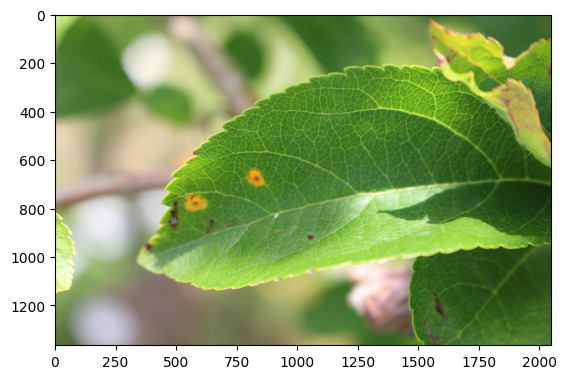

In [156]:


a = plt.imread(df_full['file_name'][3])
plt.imshow(a)

a2 = plt.imread(df_full['file_name'][5])
plt.imshow(a2)

b = plt.imread(df_full['file_name'][18])
plt.imshow(b)

b2 = plt.imread(df_full['file_name'][23])
plt.imshow(b2)

c = plt.imread(df_full['file_name'][2])
plt.imshow(c)

c2 = plt.imread(df_full['file_name'][4])
plt.imshow(c2)

d = plt.imread(df_full['file_name'][0])
plt.imshow(c)

d2 = plt.imread(df_full['file_name'][7])
plt.imshow(c2)

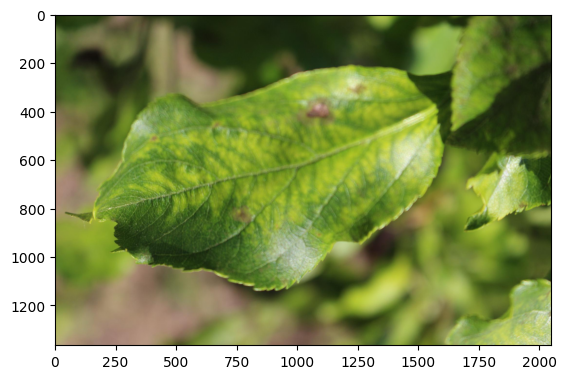

In [ ]:
a = plt.imread(df_full[df_full['scab']==1]['file_name'][0])
plt.imshow(a)

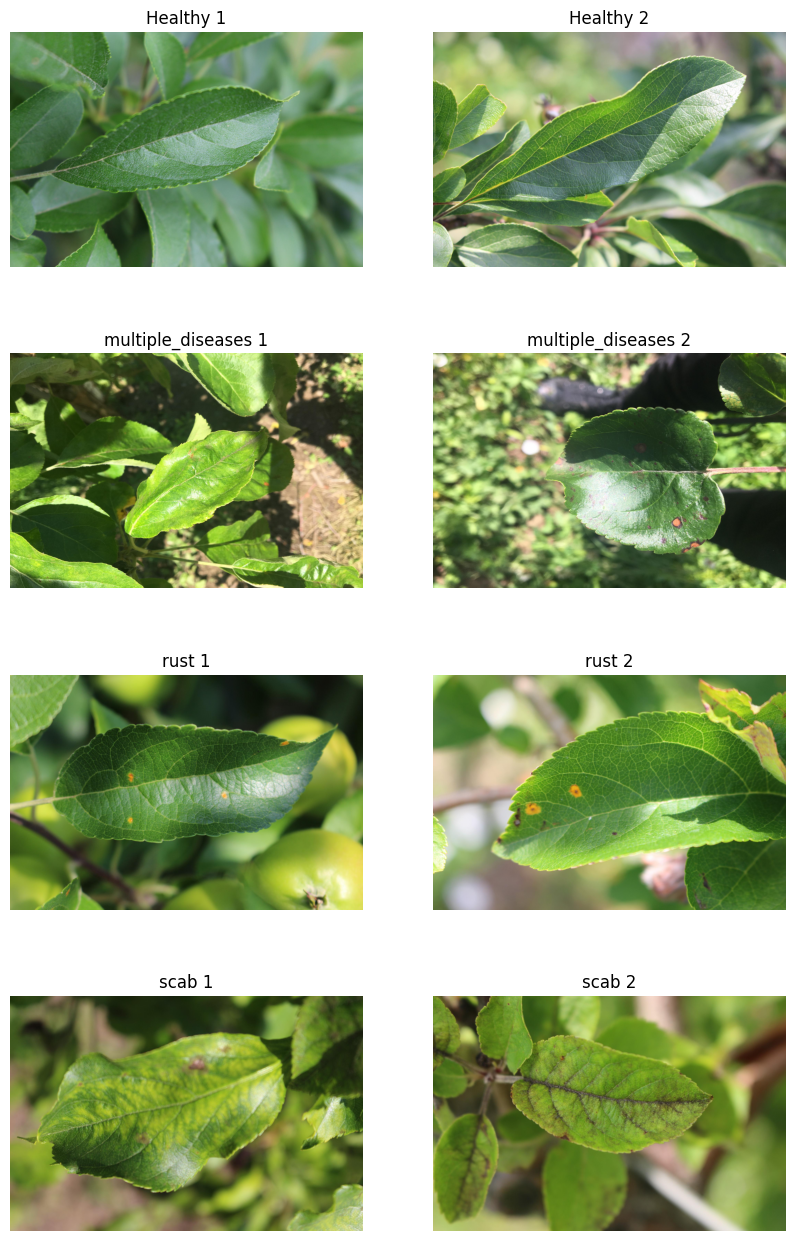

<Figure size 640x480 with 0 Axes>

In [158]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지 데이터 준비
image_data = np.random.random((100, 100))

# 2행 2열로 서브플롯 설정
import matplotlib.pyplot as plt
import numpy as np

# 그림판 크기 설정
plt.figure(figsize=(10, 16))

# 서브플롯 설정 및 이미지 출력
plt.subplot(4, 2, 1)
plt.imshow(a)
plt.title('Healthy 1')
plt.axis('off')

plt.subplot(4, 2, 2)
plt.imshow(a2)
plt.title('Healthy 2')
plt.axis('off')

plt.subplot(4, 2, 3)
plt.imshow(b)
plt.title('multiple_diseases 1')
plt.axis('off')

plt.subplot(4, 2, 4)
plt.imshow(b2)
plt.title('multiple_diseases 2')
plt.axis('off')

plt.subplot(4, 2, 5)
plt.imshow(c)
plt.title('rust 1')
plt.axis('off')

plt.subplot(4, 2, 6)
plt.imshow(c2)
plt.title('rust 2')
plt.axis('off')

plt.subplot(4, 2, 7)
plt.imshow(d)
plt.title('scab 1')
plt.axis('off')

plt.subplot(4, 2, 8)
plt.imshow(d2)
plt.title('scab 2')
plt.axis('off')

# 그래프 출력
plt.show()





# 서브플롯 간 간격 조정
plt.tight_layout()

# 그래프 출력
plt.show()


### 잎들이 4가지 종류 인데, 건강한 잎들과 다른 잎들은 차이가 있는데
### 제 식견으로 봤을땐 차이가 크게 없는거 같습니다.
### 하지만 딥러닝을 활용하면 분류를 할 수 있습니다.

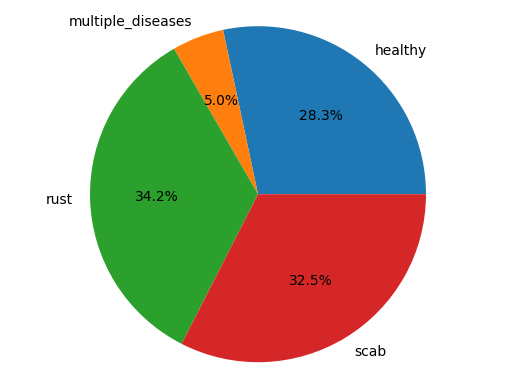

In [7]:
label_names = ["healthy", "multiple_diseases", "rust", "scab"]
label_counts = labels.sum(axis=0)

# 파이 차트 그리기
plt.pie(label_counts, labels=label_names, autopct='%1.1f%%')

# 옵션 설정
plt.axis('equal')  # 원형으로 보이도록 설정

# 차트 보여주기
plt.show()

### 여기서 데이터 불균형 문제가 발생한것을 볼 수 있 습니다.
### Multiple_diseases가 확실히 적고 rust가 가장 많이 있는것을 볼 수 있습니다.


# DATESET 의 근본적인 문제

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

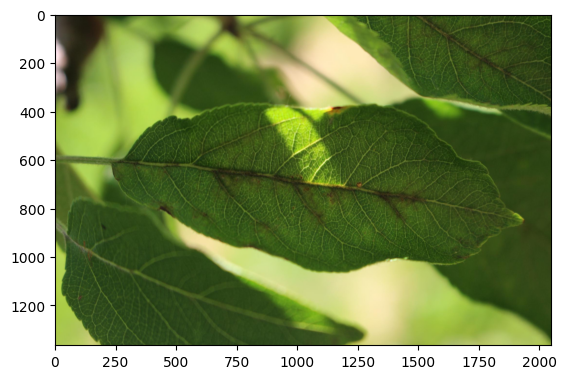

image_id             Train_379
healthy                      0
multiple_diseases            0
rust                         0
scab                         1
Name: 379, dtype: object


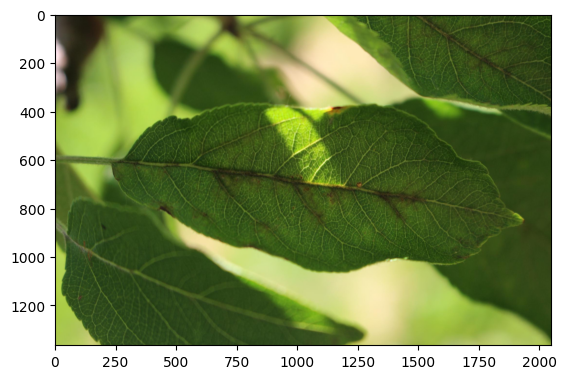

image_id             Train_1173
healthy                       0
multiple_diseases             1
rust                          0
scab                          0
Name: 1173, dtype: object


In [9]:
train_data = pd.read_csv("./plant-pathology-2020-fgvc7/train.csv")

img_379 = cv2.imread('./plant-pathology-2020-fgvc7/images/Train_379.jpg')
img_379_label = train_data.iloc[379][:]

img_1173 = cv2.imread('./plant-pathology-2020-fgvc7/images/Train_1173.jpg')
img_1173_label = train_data.iloc[1173][:]

plt.imshow(cv2.cvtColor(img_379, cv2.COLOR_BGR2RGB))
plt.show()
print(img_379_label)

plt.imshow(cv2.cvtColor(img_1173, cv2.COLOR_BGR2RGB))
plt.show()
print(img_1173_label)

### 동일한 사진인데 라벨링이 다르게 되어있음!
### 명백한 라벨링 실수가 발생해서 데이터가 오염된 상태 입니다
### 하지만 대회 규칙상 원본 데이터를 건드리는것은 금지 되있어서
### 삭제하는것은 하지 않았습니다.

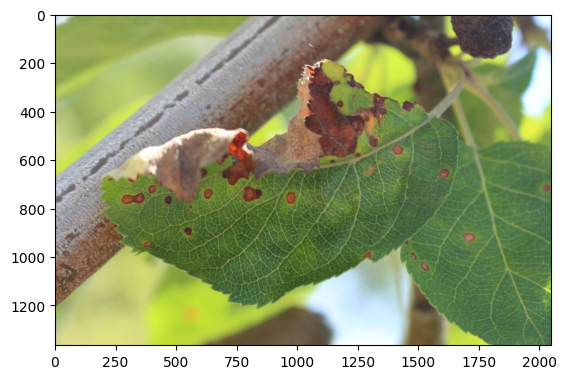

image_id             Train_1
healthy                    0
multiple_diseases          1
rust                       0
scab                       0
Name: 1, dtype: object


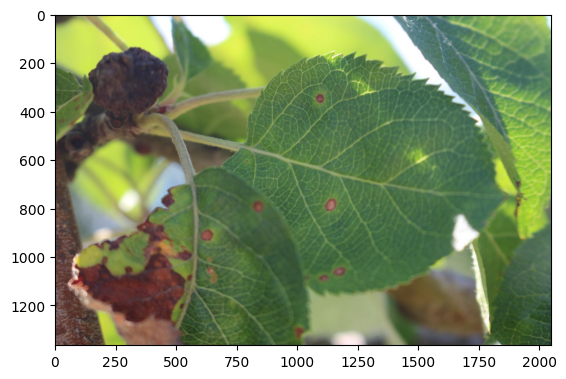

image_id             Train_171
healthy                      0
multiple_diseases            0
rust                         1
scab                         0
Name: 171, dtype: object


In [10]:
img_1 = cv2.imread('./plant-pathology-2020-fgvc7/images/Train_1.jpg')
img_1_label = train_data.iloc[1][:]

img_171 = cv2.imread('./plant-pathology-2020-fgvc7/images/Train_171.jpg')
img_171_label = train_data.iloc[171][:]

plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
plt.show()
print(img_1_label)

plt.imshow(cv2.cvtColor(img_171, cv2.COLOR_BGR2RGB))
plt.show()
print(img_171_label)

### 내가 식물학자는 아니지만... 도대체 1번 사진의 multiple diseses와 171번 그림의 rust의 차이가 무엇인지?
### 물론 정말로 다른것 일수도 있긴한데 직관적으로 봤을때는 학습에 지장을 줄 것으로 보입니다.

### 1등 한 사람이 사용했다는 knowledge distillation method 적용

#### 1차 학습 결과를 0.3 가중치로 학습용 레이블로 적용 (원본 0.7 + 1차학습 0.3 = > 새로운 학습 레이블)
#### 데이터 라벨링 실수를 중화하는 효과